# Klasifikasi Penyakit Buah Mangga

## Import Dataset dan Library


In [1]:
!gdown 1_KRRC2KriNMmWirwJyx6_qmO36-pAt3w

Downloading...
From (original): https://drive.google.com/uc?id=1_KRRC2KriNMmWirwJyx6_qmO36-pAt3w
From (redirected): https://drive.google.com/uc?id=1_KRRC2KriNMmWirwJyx6_qmO36-pAt3w&confirm=t&uuid=6f0b072a-dd25-442d-85ba-638b79cdf2d6
To: /content/MangoFruitDDS.zip
100% 63.5M/63.5M [00:00<00:00, 106MB/s]


In [2]:
!rm -rf /content/MangoFruitDDS
!unzip -q MangoFruitDDS.zip -d /content/

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

## Preprocessing

### Data Preparation

In [4]:
image_size = 224
batch_size = 32
channels = 3
epochs = 200
learning_rate = 0.00001

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/MangoFruitDDS',
    shuffle=True,
    image_size=(image_size, image_size),
    batch_size=batch_size
)
class_names = dataset.class_names
print(class_names)

Found 1700 files belonging to 5 classes.
['Alternaria', 'Anthracnose', 'Black Mould Rot', 'Healthy', 'Stem end Rot']


In [6]:
total_samples = 0
class_counts = {}

for images, labels in dataset:
  total_samples += images.shape[0]
  for label in labels.numpy():
    class_name = class_names[label]
    class_counts[class_name] = class_counts.get(class_name, 0) + 1

print("Total data:", total_samples)
print("\nData per class:")
for class_name, count in class_counts.items():
  print(f"Total citra kelas {class_name}: {count}")

Total data: 1700

Data per class:
Total citra kelas Anthracnose: 261
Total citra kelas Stem end Rot: 323
Total citra kelas Black Mould Rot: 368
Total citra kelas Healthy: 413
Total citra kelas Alternaria: 335


### Data Visualization

Visualisasi Citra: Alternaria


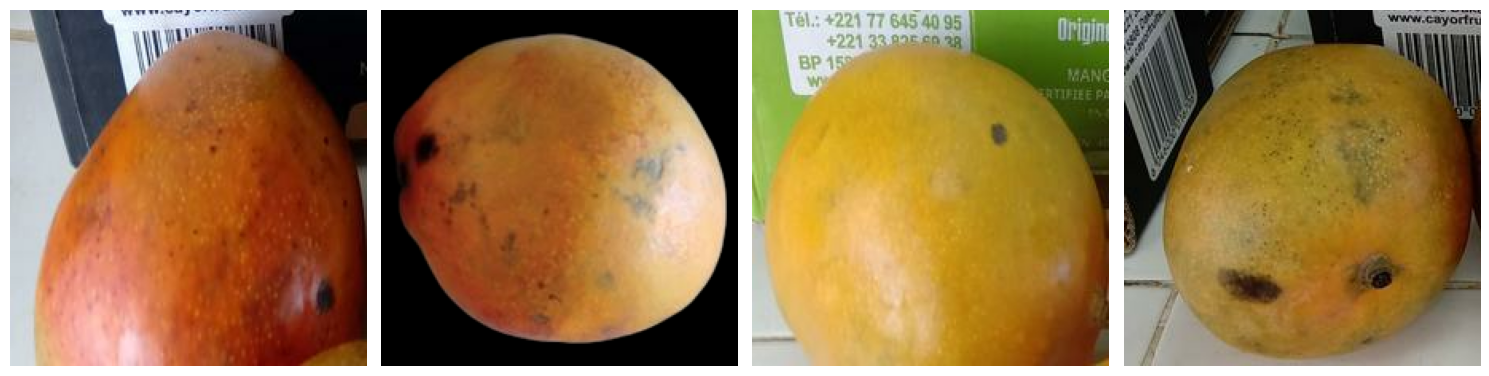

Visualisasi Citra: Anthracnose


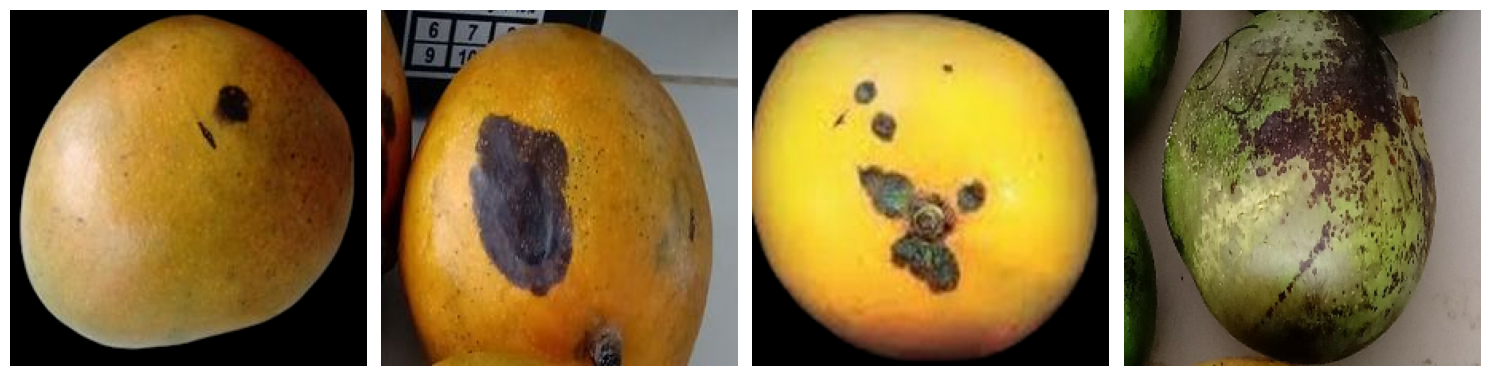

Visualisasi Citra: Black Mould Rot


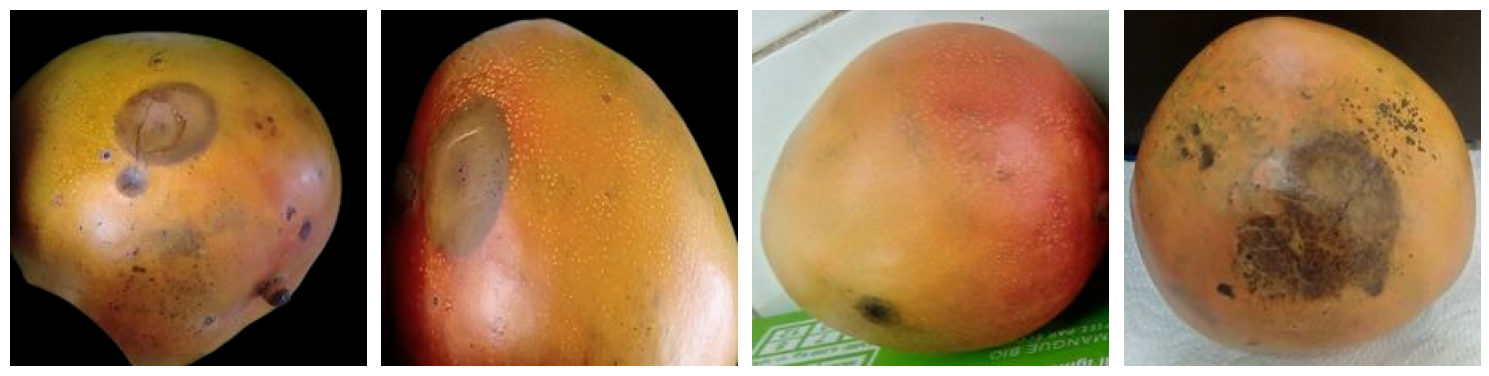

Visualisasi Citra: Healthy


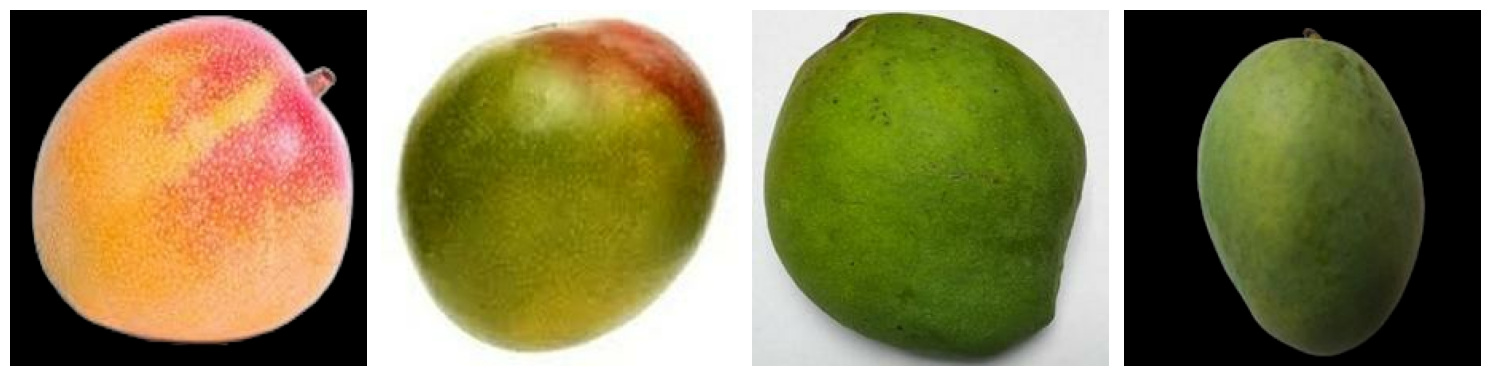

Visualisasi Citra: Stem end Rot


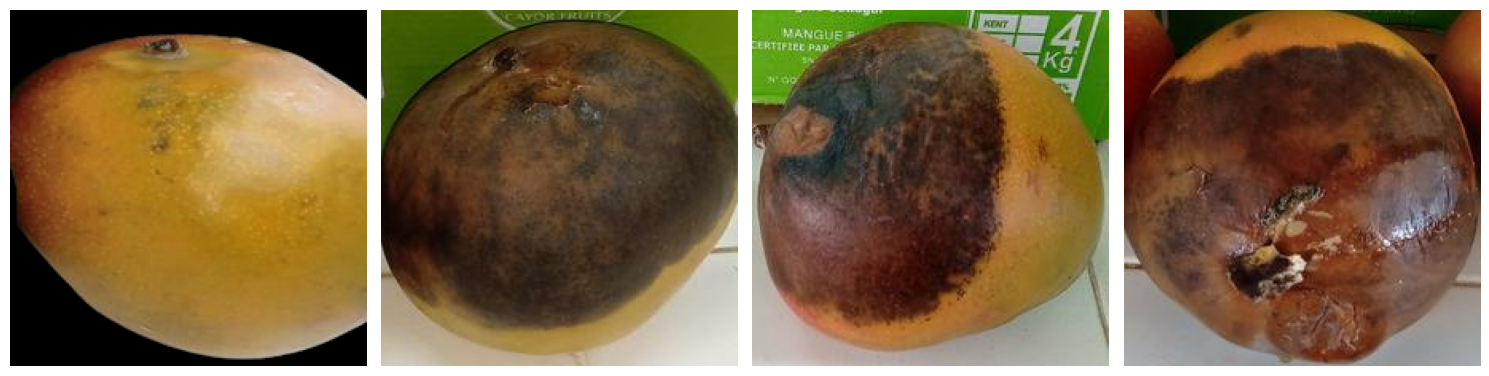

In [7]:
def visualize_images(dataset, class_names):
  for class_name in class_names:
    print(f"Visualisasi Citra: {class_name}")
    count = 0
    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    for images, labels in dataset:
      for i in range(images.shape[0]):
          if class_names[labels[i]] == class_name and count < 4:
              axes.ravel()[count].imshow(images[i].numpy().astype("uint8"))
              axes.ravel()[count].axis("off")
              count += 1
          if count == 4:
              break
      if count == 4:
          break
    plt.tight_layout()
    plt.show()

visualize_images(dataset, class_names)

### Data Splitting

In [8]:
# Membagi dataset menjadi Train dan Test

def get_dataset_partitions_tf(ds, train_split=0.8, test_split=0.2, shuffle=True, shuffle_size=10000):
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)

  train_dataset = ds.take(train_size)
  test_dataset = ds.skip(train_size)

  return train_dataset, test_dataset

train_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [9]:
print("Jumlah Batch: ", len(dataset))
print("Jumlah Batch untuk Train: ", len(train_dataset))
print("Jumlah Batch untuk Test: ", len(test_dataset))

Jumlah Batch:  54
Jumlah Batch untuk Train:  43
Jumlah Batch untuk Test:  11


### Encoding

In [10]:
for features, labels in dataset.take(1):
    print("Features shape:", features.shape)
    print("Labels shape:", labels.shape)

Features shape: (32, 224, 224, 3)
Labels shape: (32,)


In [11]:
num_classes = 5

def one_hot_encode(features, labels):
    labels = tf.one_hot(labels, depth=num_classes)
    return features, labels

train_dataset = train_dataset.map(one_hot_encode)
test_dataset = test_dataset.map(one_hot_encode)


### Data Augmentation

In [12]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(image_size, image_size),
    layers.Rescaling(1./255)
])

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
], name="data_augmentation")


In [15]:
train_dataset = train_dataset.map(lambda x, y: (resize_and_rescale(x), y))
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
test_dataset = test_dataset.map(lambda x, y: (resize_and_rescale(x), y))

## Training

### CNN Model

In [16]:
inputs = tf.keras.Input(shape=(image_size, image_size, channels))
x = layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = layers.AveragePooling2D((2,2))(x)
x = layers.Conv2D(64, (3,3), activation='relu')(x)
x = layers.AveragePooling2D((2,2))(x)
x = layers.Conv2D(64, (3,3), activation='relu')(x)
x = layers.AveragePooling2D((2,2))(x)
x = layers.Conv2D(64, (3,3), activation='relu')(x)
x = layers.AveragePooling2D((2,2))(x)
x = layers.Conv2D(64, (3,3), activation='relu')(x)
x = layers.AveragePooling2D((2,2))(x)
x = layers.Dropout(0.25)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 54, 54, 64)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 26, 26, 64)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ (None, 12, 12, 64)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_4                  │ (None, 5, 5, 64)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 232,965 (910.02 KB)

 Trainable params: 232,965 (910.02 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
print(model.input)

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=keras_tensor_6>


### Callbacks for Early Stopping

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

### Training Process

In [19]:
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    validation_data=test_dataset,
    verbose=1,
    epochs=epochs,
    callbacks= early_stopping
)

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 31s 430ms/step - accuracy: 0.1941 - loss: 1.6088 - val_accuracy: 0.3519 - val_loss: 1.6023
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 271ms/step - accuracy: 0.2390 - loss: 1.6045 - val_accuracy: 0.3519 - val_loss: 1.5973
Epoch 3/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 277ms/step - accuracy: 0.2513 - loss: 1.6009 - val_accuracy: 0.3364 - val_loss: 1.5908
Epoch 4/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 295ms/step - accuracy: 0.2850 - loss: 1.5967 - val_accuracy: 0.3488 - val_loss: 1.5834
Epoch 5/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 307ms/step - accuracy: 0.2725 - loss: 1.5921 - val_accuracy: 0.3796 - val_loss: 1.5731
Epoch 6/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 281ms/step - accuracy: 0.3330 - loss: 1.5805 - val_accuracy: 0.3765 - val_loss: 1.5599
Epoch 7/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 279ms/step - accuracy: 0.3475 - loss: 1.5684 - val_accuracy: 0.3889 - val_loss: 1.5448
Epoch 8/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 280ms/step - accuracy: 0.3369 - loss: 1.5571 - 

## Evaluation

### Accuracy and Loss

In [21]:
evaluation = model.evaluate(test_dataset)
print("Accuracy:", evaluation[1])
print("Loss:", evaluation[0])

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7377 - loss: 0.6821
Accuracy: 0.709876537322998
Loss: 0.7035884857177734


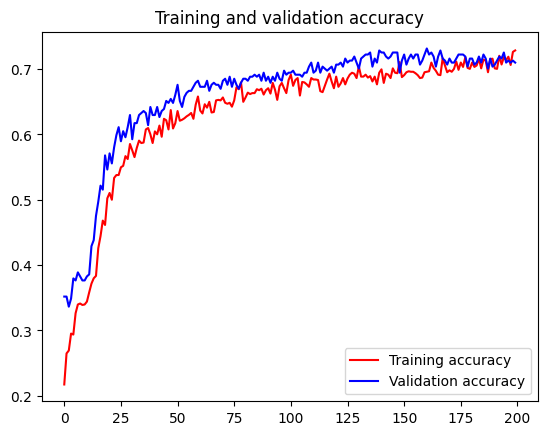

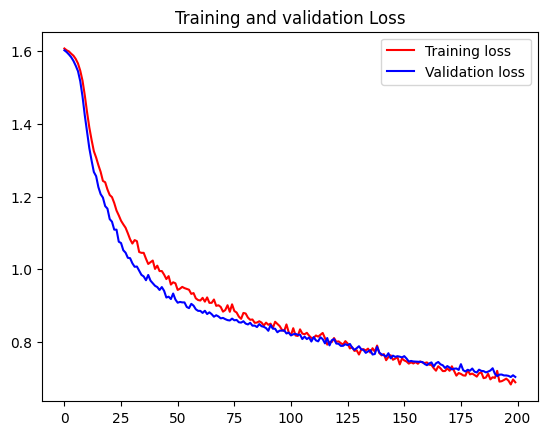

<Figure size 640x480 with 0 Axes>

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()

plt.show()

### Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


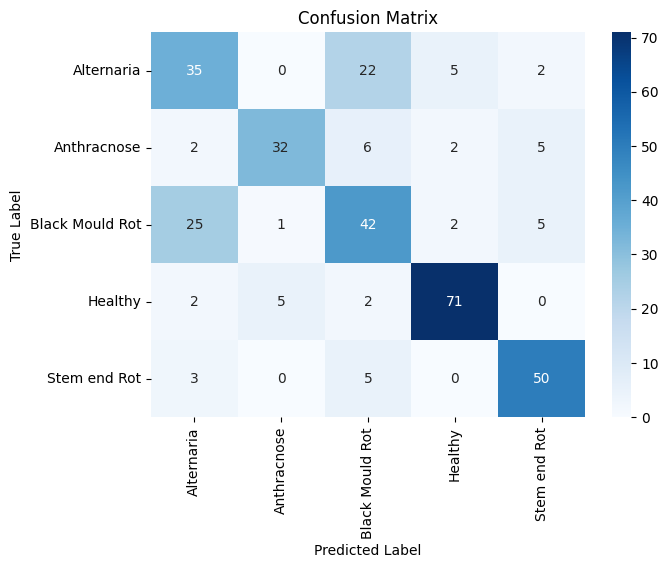

In [23]:
y_true = []
y_pred = []

for images, labels in test_dataset:
  predictions = model.predict(images)
  predicted_labels = np.argmax(predictions, axis = 1)
  true_labels = np.argmax(labels.numpy(), axis = 1)
  y_true.extend(true_labels)
  y_pred.extend(predicted_labels)

confusion_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize= (7,5))
sns.heatmap(confusion_matrix, annot=True, fmt="d",
cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### Feature Maps

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step


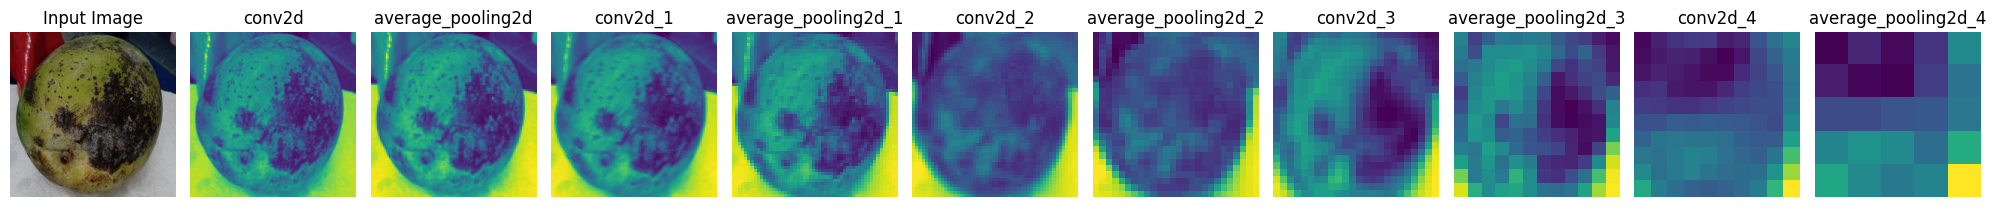

In [24]:
def plot_feature_maps_horizontal(model, image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    selected_layers = [layer for layer in model.layers if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.AveragePooling2D))]
    layer_names = [layer.name for layer in selected_layers]
    layer_outputs = [layer.output for layer in selected_layers]
    feature_map_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
    feature_maps = feature_map_model.predict(img_array)
    num_layers = len(layer_names)

    fig, axes = plt.subplots(1, num_layers + 1, figsize=(num_layers * 2, 10))

    axes[0].imshow(img_array[0])
    axes[0].set_title("Input Image")
    axes[0].axis("off")


    for idx, (layer_name, feature_map) in enumerate(zip(layer_names, feature_maps)):
        num_channels = feature_map.shape[-1]
        feature_map = feature_map[0]
        mean_activations = [np.mean(feature_map[:, :, i]) for i in range(num_channels)]
        best_channel = np.argmax(mean_activations)

        axes[idx + 1].imshow(feature_map[:, :, best_channel], cmap='viridis')
        axes[idx + 1].set_title(f"{layer_name}")
        axes[idx + 1].axis("off")

    plt.tight_layout()
    plt.show()

image_path = "/content/MangoFruitDDS/Anthracnose/anthracnose_024.jpg"
plot_feature_maps_horizontal(model, image_path)


### Visualize Prediciton

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


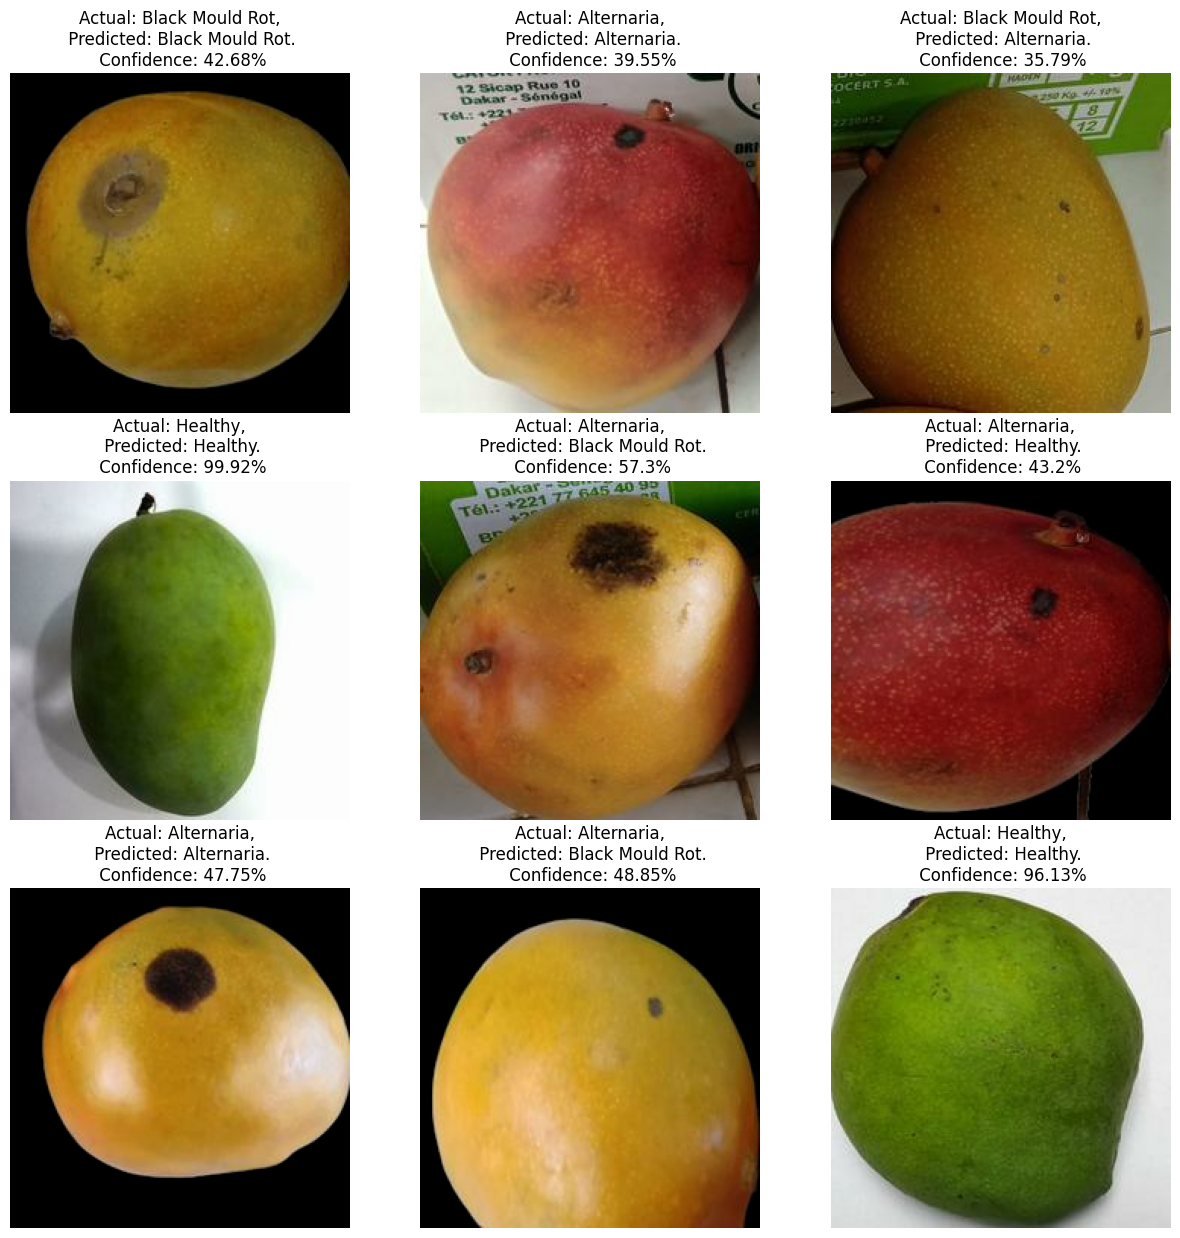

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(tf.cast(images[i] * 255.0, tf.uint8).numpy())

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[np.argmax(labels[i].numpy())]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

### Wrong Prediction

Misclassified images for class: Alternaria


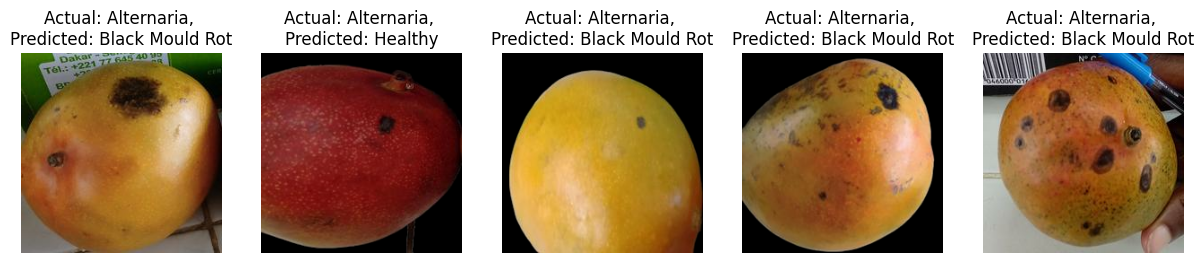

Misclassified images for class: Anthracnose


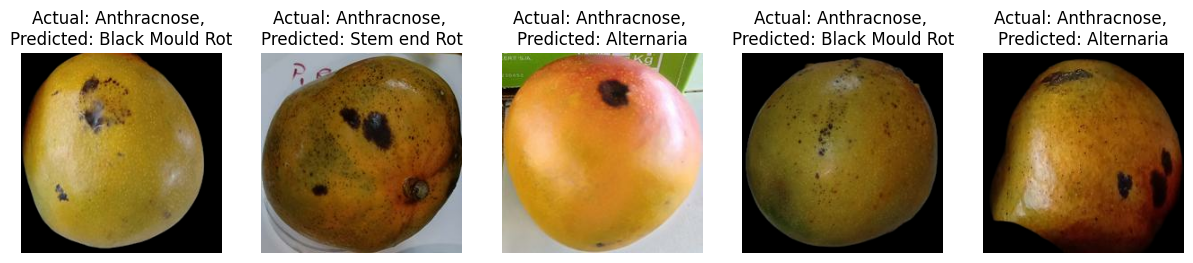

Misclassified images for class: Black Mould Rot


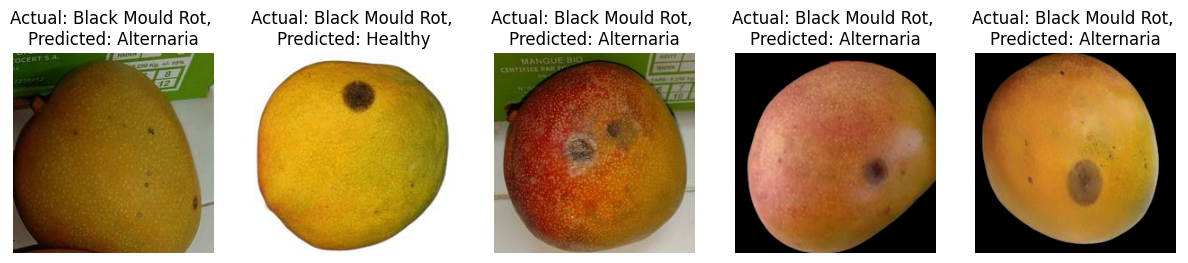

Misclassified images for class: Healthy


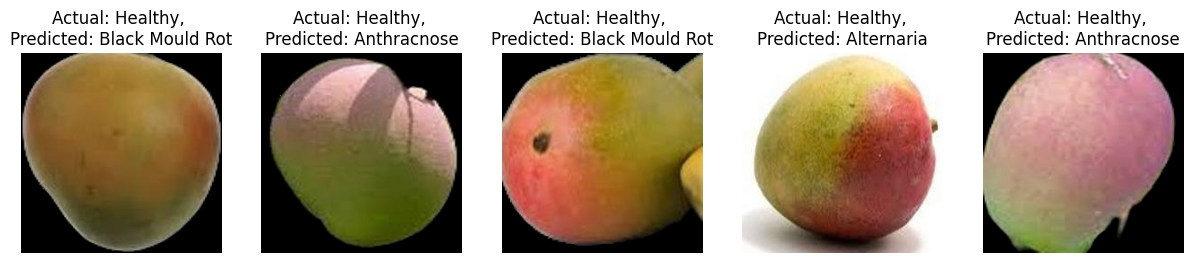

Misclassified images for class: Stem end Rot


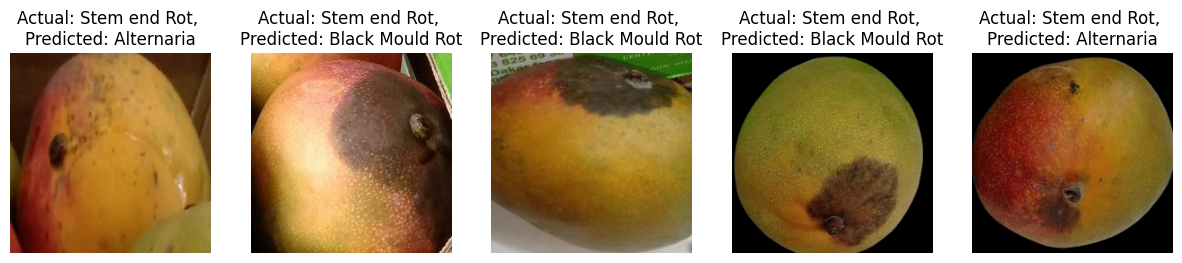

In [26]:
for class_idx in range(len(class_names)):
    misclassified_indices = np.where(
        (np.array(y_true) == class_idx) & (np.array(y_pred) != class_idx)
    )[0]

    num_images_to_display = min(5, len(misclassified_indices))
    if num_images_to_display > 0:
        print(f"Misclassified images for class: {class_names[class_idx]}")
        plt.figure(figsize=(15, 5))
        for i in range(num_images_to_display):
            idx = misclassified_indices[i]
            image, label = list(test_dataset.unbatch().skip(idx).take(1))[0]
            predicted_label = y_pred[idx]

            actual_label = np.argmax(label.numpy())

            plt.subplot(1, num_images_to_display, i + 1)
            plt.imshow(tf.cast(image * 255.0, tf.uint8).numpy())
            plt.title(
                f"Actual: {class_names[actual_label]}, \nPredicted: {class_names[predicted_label]}"
            )
            plt.axis("off")
        plt.show()


## Export Model

In [27]:
model.save('MangoFruitDDS.h5')

In [28]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Saved artifact at '/tmp/tmpjdddm8w4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_6')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  135137515379536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135137515388176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135137515375888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135137515375312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135137515377040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135137515407696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135137515408080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135137515409232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135137515409040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135137515410000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135137515408

In [29]:
tflite_model_file = pathlib.Path('MangoFruitDDS.tflite')
tflite_model_file.write_bytes(tflite_model)

937348